### set general variables and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import datetime
from datetime import timedelta
import re
import seaborn as sns
import calendar

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip

#### Set config values

In [4]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

In [5]:
chirpsgefs_dir = os.path.join(config.DROUGHTDATA_DIR,"chirps_gefs")

In [6]:
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

#### Load CHIRPS-GEFS data

In [7]:
hist_path=os.path.join(country_data_exploration_dir,"chirpsgefs","mwi_chirpsgefs_rainyseas_maxcell_test.csv")
df_chirpsgefs=pd.read_csv(hist_path)
df_chirpsgefs["date"]=pd.to_datetime(df_chirpsgefs["date"])
df_chirpsgefs["date_forec_end"]=pd.to_datetime(df_chirpsgefs["date_forec_end"])

In [8]:
#05-03-2021: chirpsgefs data before 2010 isn't yet complete--> focus on data from 2010 for now to circumvent biases
df_chirpsgefs=df_chirpsgefs[df_chirpsgefs.date.dt.year>=2010]

In [9]:
len(df_chirpsgefs)

56129

In [10]:
len(df_chirpsgefs.date.unique())

2361

In [11]:
df_chirpsgefs.date.dt.month.unique()

array([ 4, 11,  2,  3, 12,  1,  5,  6])

In [12]:
len(df_chirpsgefs.ADM2_EN.unique())

32

In [13]:
df_chirpsgefs

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,max_cell_touched,min_cell_touched,max_cell,min_cell,date_forec_end
0,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2013-04-18,2018-10-16,NaN,0.000000,0.000000,0.000000,0.000000,2013-05-03
1,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2016-11-25,2018-10-16,NaN,86.308090,61.315823,86.308090,61.315823,2016-12-10
2,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2016-02-13,2018-10-16,NaN,138.367172,89.876709,131.065704,89.876709,2016-02-28
3,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2016-02-07,2018-10-16,NaN,72.439468,34.536011,66.885689,37.520149,2016-02-22
4,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2018-03-18,2018-10-16,NaN,49.623730,22.383837,45.267921,22.383837,2018-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97619,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2016-02-22,2018-10-16,NaN,257.265137,181.405426,257.265137,257.265137,2016-03-08
97620,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2013-04-15,2018-10-16,NaN,0.000000,0.000000,0.000000,0.000000,2013-04-30
97621,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2016-11-28,2018-10-16,NaN,111.850418,93.345512,111.850418,111.850418,2016-12-13
97622,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2013-04-01,2018-10-16,NaN,54.626740,29.570948,42.932636,42.932636,2013-04-16


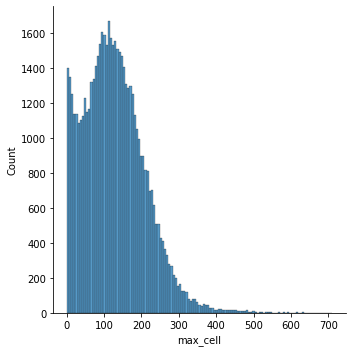

In [14]:
#that is a huge number of dry spells...
sns.displot(df_chirpsgefs,x="max_cell")

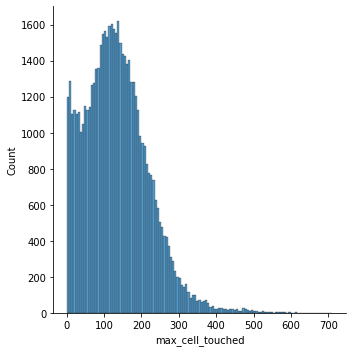

In [15]:
sns.displot(df_chirpsgefs,x="max_cell_touched")

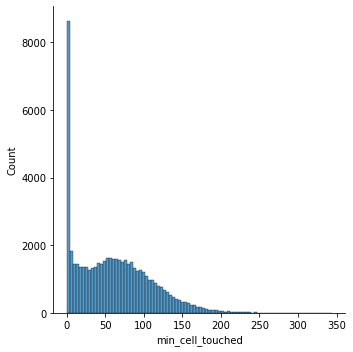

In [16]:
#check how distribution changes when using min cell touched instead of max --> even more sensitive
sns.displot(df_chirpsgefs,x="min_cell_touched")

In [17]:
print("number of adm2-date combination with min cell touched <=2mm:",len(df_chirpsgefs[df_chirpsgefs.min_cell_touched<=2]))

number of adm2-date combination with min cell touched <=2mm: 8069


In [18]:
print("number of adm2-date combination with max cell touched <=2mm:",len(df_chirpsgefs[df_chirpsgefs.max_cell_touched<=2]))

number of adm2-date combination with max cell touched <=2mm: 553


In [19]:
print("number of dates with at least one adm2 with max cell touched <=2mm:",len(df_chirpsgefs[df_chirpsgefs.max_cell_touched<=2].date.unique()))

number of dates with at least one adm2 with max cell touched <=2mm: 147


In [20]:
print("number of adm2-date combination with max cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.max_cell<=2]))

number of adm2-date combination with max cell <=2mm: 662


In [21]:
print("number of dates with at least one adm2 with max cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.max_cell<=2].date.unique()))

number of dates with at least one adm2 with max cell <=2mm: 179


### Observed dryspells and correlation with forecasted dry spells
Process the observed dryspell list as outputed by `malawi/scripts/mwi_chirps_dry_spell_detection.R` and correlate the occurence of a dry spell with the forecasted CHIRPS-GEFS dry spell

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

For simplicity we are only focusing on forecasting the first 15 days of a dry spell, i.e. the start date of the dry spell corresponds with the start date of the forecast   
This might be too simple, e.g. might want to forecast if a dry spell that already started will persist.

For now this means that if the start_date of the forecast occurs in the dry spell list, we classify it is a true positive

In [22]:
df_ds=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","dry_spells_during_rainy_season_list_2000_2020.csv"))
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])

In [23]:
df_ds

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region
0,MW101,Chitipa,2008,2009-04-08,2009-04-25,18,0.0,Northern
1,MW103,Nkhata Bay,2002,2003-04-13,2003-04-30,18,0.0,Northern
2,MW103,Nkhata Bay,2008,2009-04-06,2009-05-02,27,0.0,Northern
3,MW103,Nkhata Bay,2011,2012-04-19,2012-05-02,14,0.0,Northern
4,MW103,Nkhata Bay,2017,2018-04-17,2018-04-30,14,0.0,Northern
...,...,...,...,...,...,...,...,...
159,MW315,Blantyre City,2010,2011-04-10,2011-05-19,40,0.0,Southern
160,MW315,Blantyre City,2012,2013-03-21,2013-04-03,14,0.0,Southern
161,MW315,Blantyre City,2014,2015-04-01,2015-04-14,14,0.0,Southern
162,MW315,Blantyre City,2018,2019-03-21,2019-04-16,27,0.0,Southern


In [24]:
#number of historically observed dry spells
#this is waay less than the predicted..
len(df_ds)

164

In [25]:
#combine chirpsgefs and observed dryspells data
#merge on right to include all dates
df_comb=df_ds.merge(df_chirpsgefs[["ADM2_EN","max_cell_touched","min_cell_touched","max_cell","min_cell","date","date_forec_end"]],how="right",left_on=["dry_spell_first_date","ADM2_EN"],right_on=["date","ADM2_EN"])

In [26]:
df_comb

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,max_cell_touched,min_cell_touched,max_cell,min_cell,date,date_forec_end
0,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,2013-04-18,2013-05-03
1,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,86.308090,61.315823,86.308090,61.315823,2016-11-25,2016-12-10
2,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,138.367172,89.876709,131.065704,89.876709,2016-02-13,2016-02-28
3,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,72.439468,34.536011,66.885689,37.520149,2016-02-07,2016-02-22
4,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,49.623730,22.383837,45.267921,22.383837,2018-03-18,2018-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56124,NaN,Zomba City,NaN,NaT,NaT,NaN,NaN,NaN,257.265137,181.405426,257.265137,257.265137,2016-02-22,2016-03-08
56125,NaN,Zomba City,NaN,NaT,NaT,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,2013-04-15,2013-04-30
56126,NaN,Zomba City,NaN,NaT,NaT,NaN,NaN,NaN,111.850418,93.345512,111.850418,111.850418,2016-11-28,2016-12-13
56127,NaN,Zomba City,NaN,NaT,NaT,NaN,NaN,NaN,54.626740,29.570948,42.932636,42.932636,2013-04-01,2013-04-16


In [27]:
#nan = there was a forecast but no observed dry spell--> set occurence of dry spell to zero
#again, only looking at if any dry spell started on that date, not whether it persisted
df_comb["dryspell_obs"]=np.where(df_comb.dry_spell_first_date.notna(),1,0)

In [28]:
#set definition of forecasted dry spell as max cell having not more than 2 mm of rains in 15 days period
df_comb["dryspell_forec"]=np.where(df_comb.max_cell<=2,1,0)

In [29]:
# Aaah somehow dry spells went missing when merging on the forecast list
#reason not all data till 2010 is included yet and part of data 2020 is missing..
#TODO: check how (might have to do with missing data in 2020..)
len(df_comb[df_comb.dryspell_obs==1])

86

[[55387   656]
 [   80     6]]


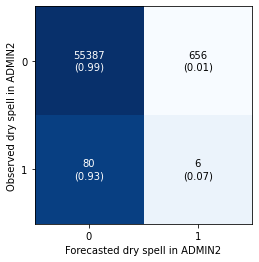

In [30]:
#compute the contigency table
#Damnn that correlation between obsrved and forecasted is waay less than I expected.. 
#Need to further understand why and if this is really the case or bug somewhere
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb["dryspell_obs"]
y_predicted = df_comb["dryspell_forec"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

[[55496   547]
 [   80     6]]


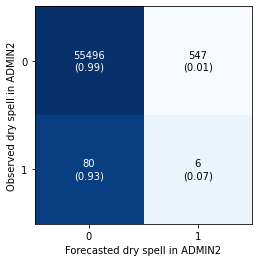

In [31]:
#compute the contigency table when using max cell touched instead
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb["dryspell_obs"]
y_predicted = np.where(df_comb["max_cell_touched"]<=2,1,0)

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

[[48446  7597]
 [   42    44]]


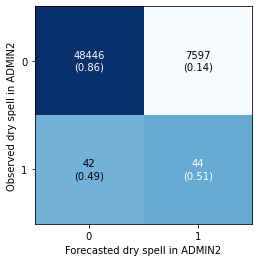

In [32]:
#compute the contigency table when using min cell touched
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

y_target =    df_comb["dryspell_obs"]
y_predicted = np.where(df_comb["min_cell"]<=2,1,0)

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

### Understand differences patterns observed and forecasted dry spells
- Definition of observed dry spell is stricter than forecasted --> can be a reason for overpredicting
- Dry spell is at least 14 days while forecasted period is 15 days --> can be a reason for underpredicting

In [33]:
#sum of dryspells per adm2, doesn't mean they occured on the same dates
#could add fraction obs/forec
df_comb.groupby("ADM2_EN").sum()[["dryspell_forec","dryspell_obs"]]#.date.sort_values().unique()

,dryspell_forec,dryspell_obs
ADM2_EN,,
Balaka,43,4
Blantyre,26,2
Blantyre City,14,4
Chikwawa,9,3
Chiradzulu,25,5
Chitipa,10,0
Dedza,39,2
Dowa,23,5
Karonga,15,0


Text(0.5, 1.0, 'Observed and forecasted dryspells')

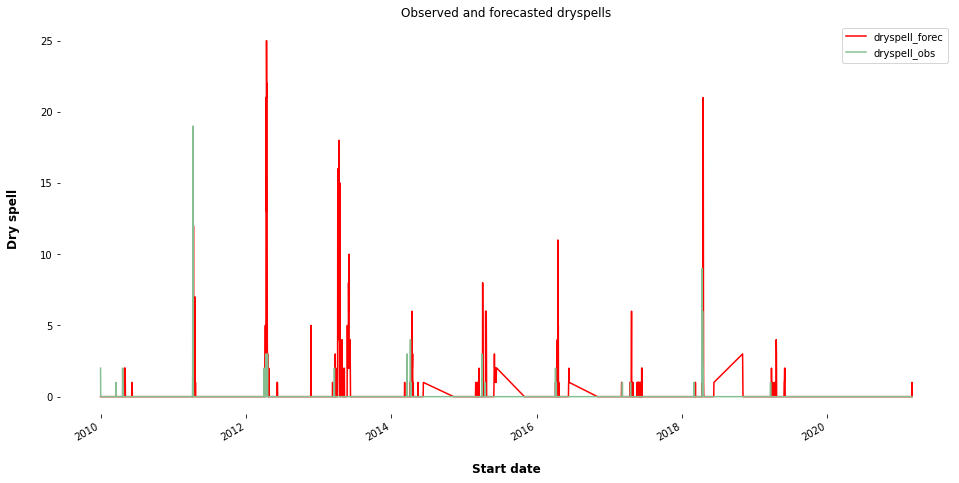

In [34]:
#number of adm2s with dryspell for forecasted and observed over time
#the diagonal lines are caused by the last day of a rainy season having a forecasted dry spell
from matplotlib.ticker import StrMethodFormatter
fig,ax=plt.subplots()
df_comb_date=df_comb.groupby("date",as_index=False).sum()
df_comb_date.sort_values(by="date").plot(x="date",y="dryspell_forec" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_comb_date.sort_values(by="date").plot(x="date",y="dryspell_obs" ,figsize=(16, 8), color='#86bf91',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Dry spell", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Observed and forecasted dryspells")

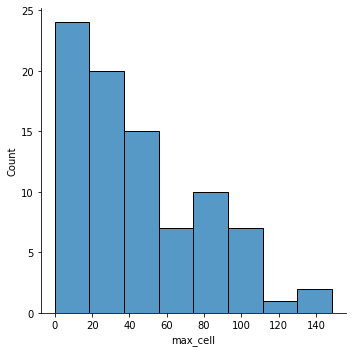

In [36]:
#check distribution of values for dates-adm2s that dry spell was observed
#not like most values are close to 0
sns.displot(df_comb[df_comb.dryspell_obs==1],x="max_cell")

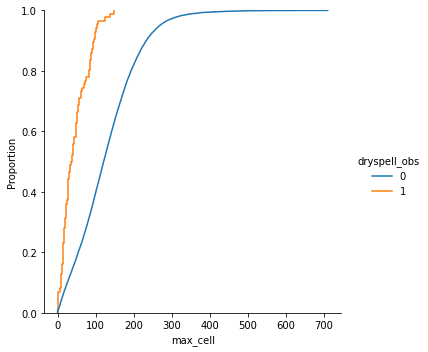

In [37]:
#check distribution of values for dates-adm2s that dry spell was observed
#not like most values are close to 0
sns.displot(df_comb,x="max_cell",kind="ecdf",hue="dryspell_obs")

Text(0.5, 0, 'max. forecasted precipitation (mm)')

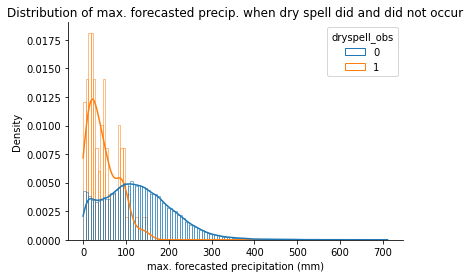

In [38]:
g=sns.histplot(
    df_comb,x="max_cell",hue="dryspell_obs",
    stat="density", common_norm=False, kde=True,fill=False
)
ax=g.axes
plt.title("Distribution of max. forecasted precip. when dry spell did and did not occur")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("max. forecasted precipitation (mm)")

<AxesSubplot:xlabel='max_cell', ylabel='Density'>

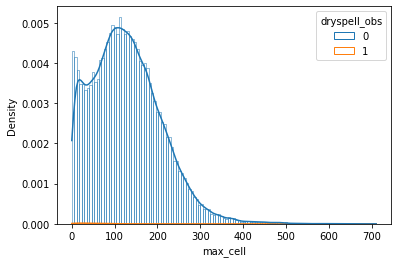

In [39]:
sns.histplot(
    df_comb,x="max_cell",hue="dryspell_obs",
    stat="density", common_norm=True, kde=True,fill=False
)

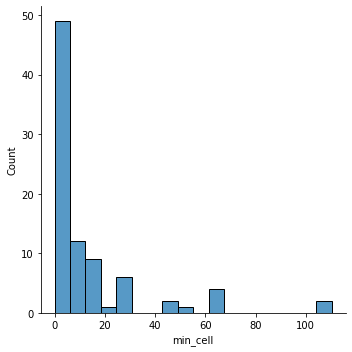

In [40]:
#when looking at min_cell, most cells do have below 20mm rainfall
#might be able to do some thresholding on that (but if only doing min_cell<=20mm then waaay too sensitive)
sns.displot(df_comb[df_comb.dryspell_obs==1],x="min_cell")

<AxesSubplot:xlabel='min_cell', ylabel='Density'>

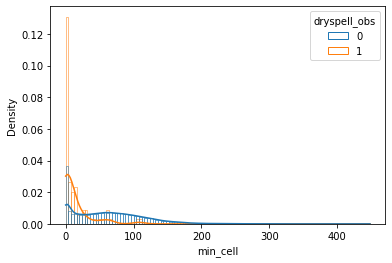

In [41]:
sns.histplot(
    df_comb,x="min_cell",hue="dryspell_obs",
    stat="density", common_norm=False, kde=True,fill=False
)

In [42]:
#understand monthly patterns observed vs forecasted
df_comb["month"]=df_comb.date.dt.month

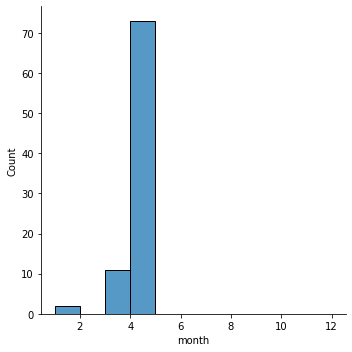

In [43]:
#observed dry spells per month
sns.displot(df_comb[df_comb.dryspell_obs==1],bins=range(df_comb.month.min(),df_comb.month.max()+1),x="month")

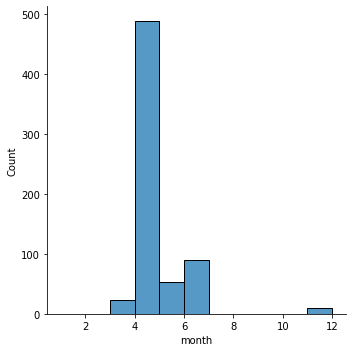

In [44]:
#forecasted dry spells per month
sns.displot(df_comb[df_comb.dryspell_forec==1],bins=range(df_comb.month.min(),df_comb.month.max()+1),x="month")

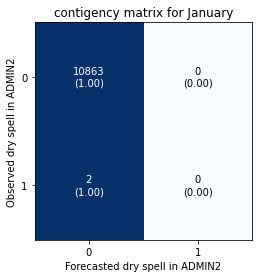

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


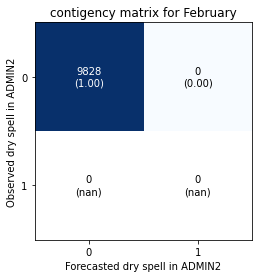

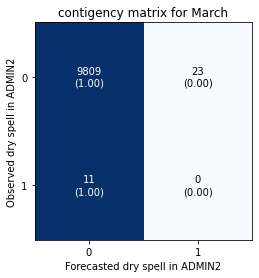

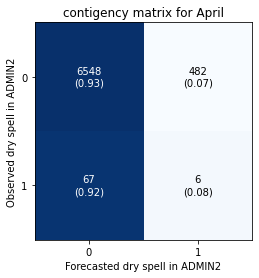

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


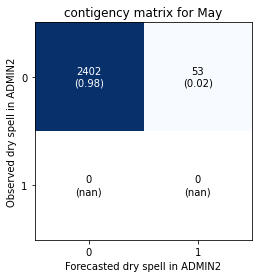

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


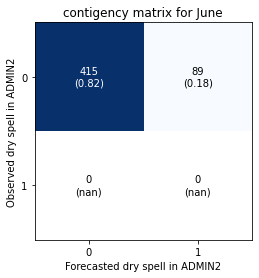

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


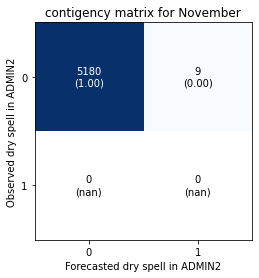

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


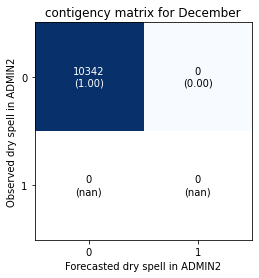

In [45]:
#compute the contigency table per month
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

for m in df_comb.sort_values(by="month").month.unique():

    y_target =    df_comb.loc[df_comb.month==m,"dryspell_obs"]
    y_predicted = df_comb.loc[df_comb.month==m,"dryspell_forec"]

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
#     print(cm)
#     print(calendar.month_name[m])
#     print(f"contigency matrix for {pd.to_datetime(m).strftime('%B')}")
    fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed dry spell in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
#     print(m)
    ax.set_title(f"contigency matrix for {calendar.month_name[m]}")
    plt.show()

#### Num adm2s dry spell forecasted vs observed
there might be too much noise in only looking at adm2 level --> investigate if there is a correlation when looking at #of adm2s forecasted/observed per adm1 and on national level

In [46]:
#compute number of adm2s with dryspell per date
df_numadm=df_comb.groupby("date")[["dryspell_obs","dryspell_forec"]].sum()

In [47]:
df_numadm

,dryspell_obs,dryspell_forec
date,,
2010-01-01,2,0
2010-01-02,0,0
2010-01-03,0,0
2010-01-04,0,0
2010-01-05,0,0
...,...,...
2021-02-26,0,0
2021-02-27,0,0
2021-02-28,0,0


<AxesSubplot:xlabel='dryspell_obs', ylabel='dryspell_forec'>

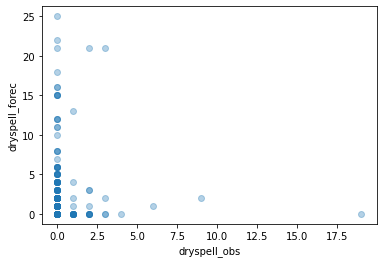

In [48]:
#darker shade means higher density of values
#-->not really clear pattern..
sns.regplot(data = df_numadm, x = 'dryspell_obs', y = 'dryspell_forec', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)

In [49]:
df_bound_adm2=gpd.read_file(adm2_bound_path)

In [50]:
df_comb=df_comb.merge(df_bound_adm2[["ADM1_EN","ADM2_EN"]],on="ADM2_EN",how="left")
# df_comb=df_comb.rename({"ADM1_EN":"region"})

In [51]:
df_numadm1=df_comb.groupby(["date","ADM1_EN"],as_index=False)[["dryspell_obs","dryspell_forec"]].sum()

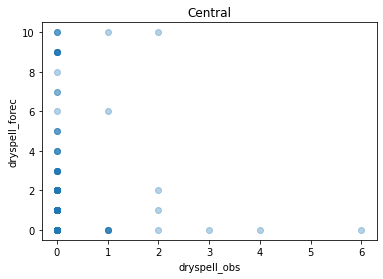

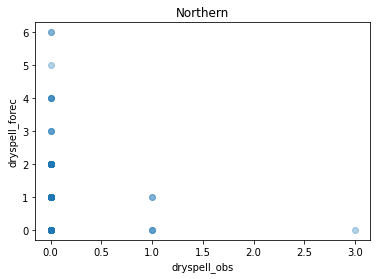

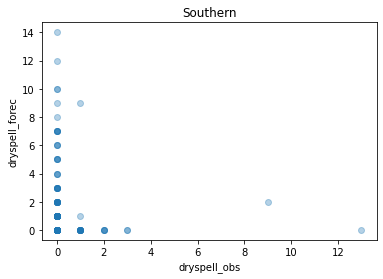

In [52]:
for a in df_numadm1.ADM1_EN.unique():
    g=sns.regplot(data = df_numadm1[df_numadm1.ADM1_EN==a], x = 'dryspell_obs', y = 'dryspell_forec', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)
    g.axes.set_title(a)
    plt.show()

[[2160  167]
 [  22   12]]


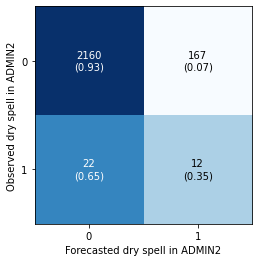

In [84]:
#compute the contigency table per date
#Damnn that correlation between obsrved and forecasted is waay less than I expected.. 
#Need to further understand why and if this is really the case or bug somewhere
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_comb_date=df_comb.groupby("date",as_index=False).sum()
df_comb_date["dryspell_obs_bool"]=np.where(df_comb_date.dryspell_obs>=1,1,0)
df_comb_date["dryspell_forec_bool"]=np.where(df_comb_date.dryspell_forec>=1,1,0)

y_target =    df_comb_date["dryspell_obs_bool"]
y_predicted = df_comb_date["dryspell_forec_bool"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

[[50 20]
 [ 2 13]]


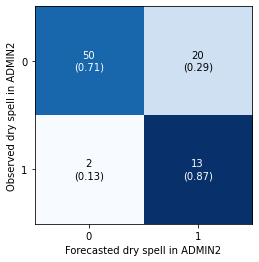

In [88]:
#compute the contigency table per date
#Damnn that correlation between obsrved and forecasted is waay less than I expected.. 
#Need to further understand why and if this is really the case or bug somewhere
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_comb["date_month"]=df_comb.date.dt.to_period("M")
df_comb_month=df_comb.groupby("date_month",as_index=False).sum()
df_comb_month["dryspell_obs_bool"]=np.where(df_comb_month.dryspell_obs>=1,1,0)
df_comb_month["dryspell_forec_bool"]=np.where(df_comb_month.dryspell_forec>=1,1,0)

y_target =    df_comb_month["dryspell_obs_bool"]
y_predicted = df_comb_month["dryspell_forec_bool"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

### Discrepancy forecasted and observed rainfall

In [53]:
#read historically observed 14 day rolling sum for all dates (so not only those with dry spells)
df_hist14d=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","data_max_values_long.csv"))
df_hist14d.date=pd.to_datetime(df_hist14d.date)

In [54]:
#add start of the rolling sum 
df_hist14d["date_start"]=df_hist14d.date-timedelta(days=13)

In [55]:
df_hist14d.head()

,ID,pcode,season_approx,date,total_prec,year,month,day,rollsum_10d,rollsum_14d,...,rainy_day_bin,onset_date,cessation_date,rainy_season_duration,onset_month,cessation_month,during_rainy_season_bin,nth_day_of_rainy_season,rollsum_14d_less_than_2_bin,date_start
0,1,MW312,1999,2000-02-01,24.073183,2000,2,1,178.731942,204.893187,...,1,NaN,2000-04-26,NaN,NaN,4.0,NaN,NaN,0.0,2000-01-19
1,1,MW312,1999,2000-02-28,4.227058,2000,2,28,124.607780,179.926726,...,1,NaN,2000-04-26,NaN,NaN,4.0,NaN,NaN,0.0,2000-02-15
2,1,MW312,1999,2000-03-26,15.511610,2000,3,26,103.492470,127.553702,...,1,NaN,2000-04-26,NaN,NaN,4.0,NaN,NaN,0.0,2000-03-13
3,1,MW312,1999,2000-03-27,0.000000,2000,3,27,103.492470,118.174504,...,0,NaN,2000-04-26,NaN,NaN,4.0,NaN,NaN,0.0,2000-03-14
4,1,MW312,1999,2000-07-24,6.125876,2000,7,24,11.989682,11.989682,...,1,NaN,2000-04-26,NaN,NaN,4.0,0.0,NaN,0.0,2000-07-11


In [56]:
#add adm2 name
df_hist14d=df_hist14d.merge(df_bound_adm2[["ADM1_EN","ADM2_EN","ADM2_PCODE"]],left_on="pcode",right_on="ADM2_PCODE")

In [57]:
df_histformerg=df_hist14d.merge(df_chirpsgefs,left_on=["date_start","ADM2_EN"],right_on=["date","ADM2_EN"],suffixes=("obs","forec"))

In [58]:
df_histformerg["diff_precip"]=df_histformerg["rollsum_14d"]-df_histformerg["max_cell"]

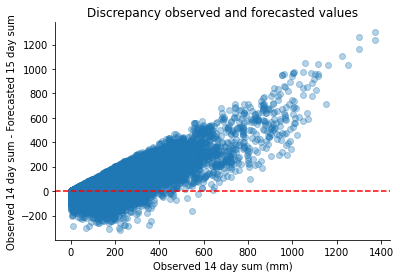

In [59]:
g=sns.regplot(data=df_histformerg,y="diff_precip",x="rollsum_14d",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.set_xlabel("Observed 14 day sum (mm)")
ax.set_ylabel("Observed 14 day sum - Forecasted 15 day sum")
ax.set_title("Discrepancy observed and forecasted values")
ax.axhline(0, ls='--',color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

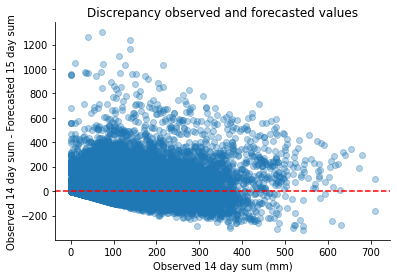

In [60]:
g=sns.regplot(data=df_histformerg,y="diff_precip",x="max_cell",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.set_xlabel("Observed 14 day sum (mm)")
ax.set_ylabel("Observed 14 day sum - Forecasted 15 day sum")
ax.set_title("Discrepancy observed and forecasted values")
ax.axhline(0, ls='--',color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

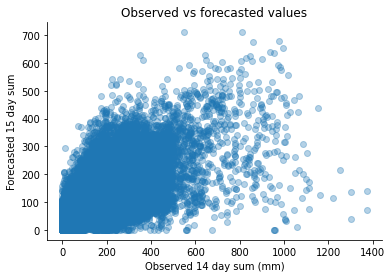

In [61]:
g=sns.regplot(data=df_histformerg,y="max_cell",x="rollsum_14d",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.set_xlabel("Observed 14 day sum (mm)")
ax.set_ylabel("Forecasted 15 day sum")
ax.set_title("Observed vs forecasted values")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Text(0.5, 1.0, 'Discrepancy observed and forecasted values when observed<=10mm')

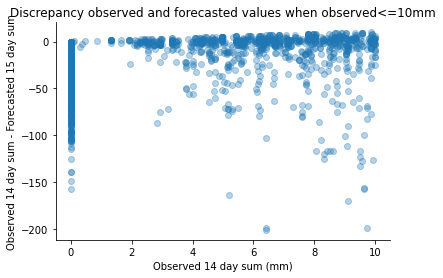

In [62]:
g=sns.regplot(data=df_histformerg[df_histformerg.rollsum_14d<=10],y="diff_precip",x="rollsum_14d",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Observed 14 day sum (mm)")
ax.set_ylabel("Observed 14 day sum - Forecasted 15 day sum")
ax.set_title("Discrepancy observed and forecasted values when observed<=10mm")

In [63]:
#todo:boxplot

#### Visualizing the rasters

In [64]:
import cftime

In [65]:
ds_list=[]
for d in df_comb[df_comb.dryspell_obs==1].date.unique():
    d_str=pd.to_datetime(d).strftime("%Y%m%d")
    filename=f"chirpsgefs_africa_{d_str}.tif"
    rds=rioxarray.open_rasterio(os.path.join(chirpsgefs_dir,filename))
    rds=rds.assign_coords({"time":pd.to_datetime(d)})
    rds=rds.sel(band=1)
    ds_list.append(rds)

In [66]:
# ds_list=[]
# chirps_dir=os.path.join(config.DATA_DIR,"raw","drought","chirps")
# for y in df_comb[df_comb.dryspell_obs==1].date.dt.year.unique():
# #     d_str=pd.to_datetime(d).strftime("%Y%m%d")

#     filename=f"chirps_global_daily_{y}_p05.nc"# f"chirpsgefs_africa_{d_str}.tif"
#     rds=rioxarray.open_rasterio(os.path.join(chirps_dir,filename))
#     rds=rds.assign_coords({"year":y})
# #     rds=rds.sel(band=1)
#     ds_list.append(rds)
# ds_chirps=xr.concat(ds_list,dim="year")

In [67]:
ds_list[0]

<xarray.DataArray (y: 1600, x: 1500)>
[2400000 values with dtype=float32]
Coordinates:
    band         int64 1
  * y            (y) float64 39.97 39.92 39.87 39.82 ... -39.88 -39.93 -39.98
  * x            (x) float64 -19.97 -19.92 -19.87 -19.82 ... 54.88 54.93 54.98
    spatial_ref  int64 0
    time         datetime64[ns] 2014-04-07
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [68]:
ds_drys=xr.concat(ds_list,dim="time")

In [69]:
ds_drys=ds_drys.sortby("time")

In [70]:
df_bound_adm2 = gpd.read_file(adm2_bound_path)
df_bound_adm1 = gpd.read_file(adm1_bound_path)
ds_drys_clip = ds_drys.rio.clip(df_bound_adm1.geometry.apply(mapping), df_bound_adm1.crs, all_touched=True)

In [71]:
# df_comb_adm1=df_comb.merge(df_bound_adm2[["ADM2_EN","ADM1_EN"]],on="ADM2_EN",how="left")

In [72]:
df_adm1_grouped=df_comb[df_comb.dryspell_obs==1].groupby(["ADM1_EN","date"],as_index=False).count()

In [73]:
df_comb.groupby("ADM1_EN").count()

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,max_cell_touched,min_cell_touched,max_cell,min_cell,date,date_forec_end,dryspell_obs,dryspell_forec,month
ADM1_EN,,,,,,,,,,,,,,,,,
Central,28,17501,28,28,28,28,28,28,17501,17501,17501,17501,17501,17501,17501,17501,17501
Northern,8,13455,8,8,8,8,8,8,13455,13455,13455,13455,13455,13455,13455,13455,13455
Southern,50,25173,50,50,50,50,50,50,25173,25173,25173,25173,25173,25173,25173,25173,25173


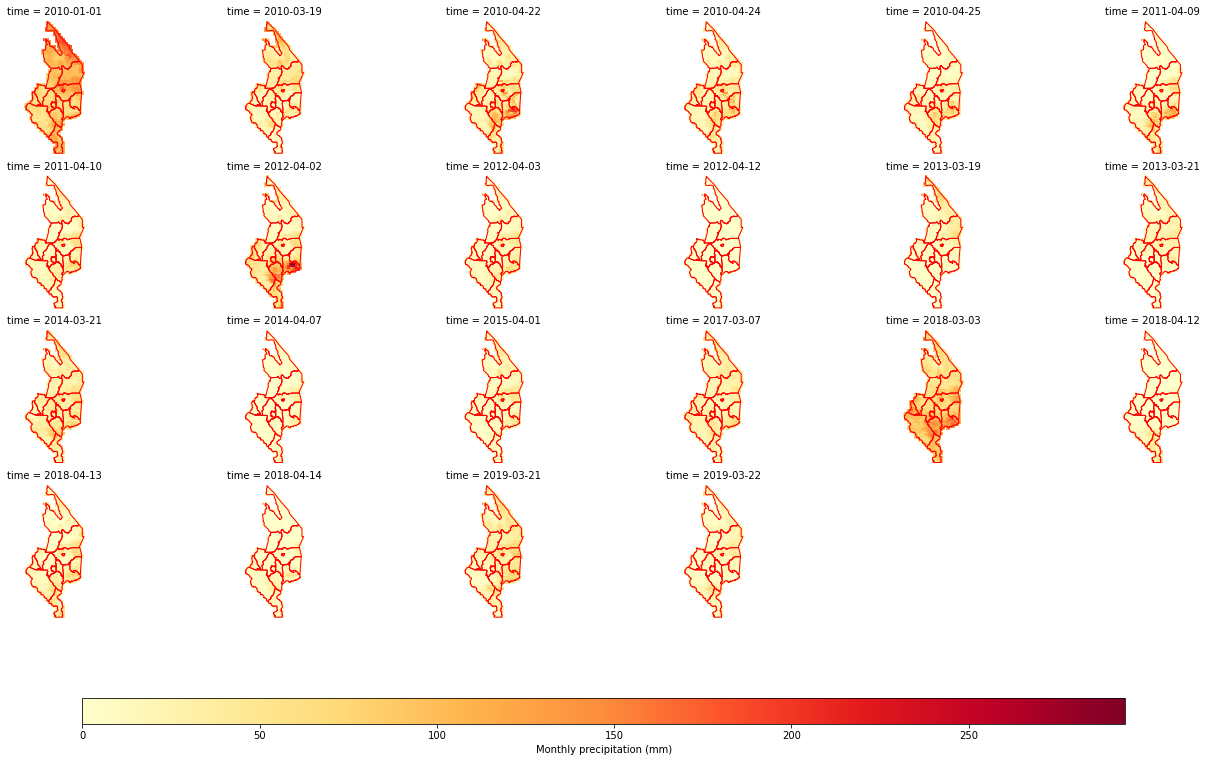

In [74]:
for a in ["Southern"]:#df_adm1_grouped.ADM1_EN.unique():
    df_bound_sel_adm=df_bound_adm2[df_bound_adm2.ADM1_EN==a]
    ds_drys_clip_adm = ds_drys.rio.clip(df_bound_sel_adm.geometry.apply(mapping), df_bound_sel_adm.crs, all_touched=True)
    df_adm1_grouped[df_adm1_grouped.ADM1_EN==a].date.unique()
    g=ds_drys_clip_adm.sel(time=ds_drys_clip_adm.time.isin(df_adm1_grouped[df_adm1_grouped.ADM1_EN==a].date.unique())).plot(
    col="time",
    col_wrap=6,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label":"Monthly precipitation (mm)"
    },
    cmap="YlOrRd",
)

    # df_bound = gpd.read_file(adm1_bound_path)
    for ax in g.axes.flat:
        df_bound_sel_adm.boundary.plot(linewidth=1, ax=ax, color="red")
        ax.axis("off")

Balaka
Blantyre
Blantyre City
Chikwawa
Chiradzulu
Dedza
Dowa
Kasungu
Lilongwe
Lilongwe City
Machinga
Mangochi
Mchinji
Mulanje
Mwanza
Mzimba
Mzuzu City
Neno
Nkhata Bay
Nkhotakota
Nsanje
Ntcheu
Ntchisi
Phalombe
Rumphi
Salima


/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/xarray/plot/facetgrid.py:164: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(


Thyolo
Zomba
Zomba City


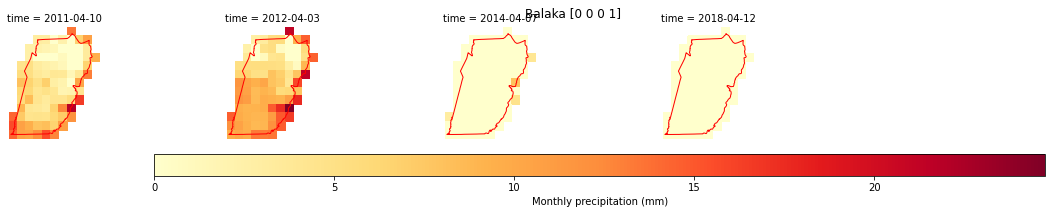

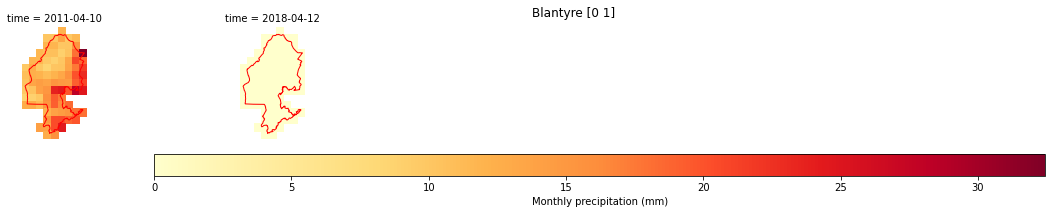

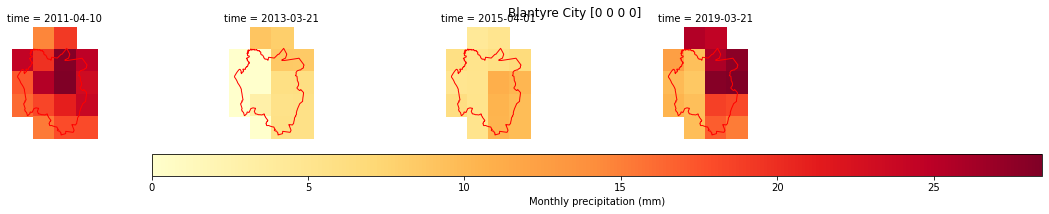

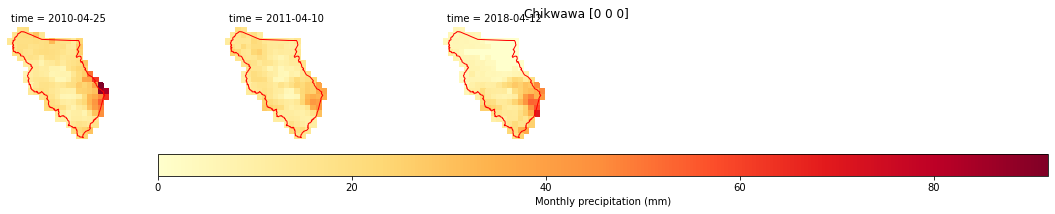

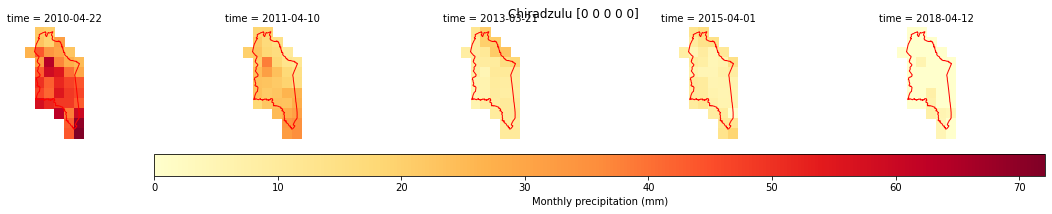

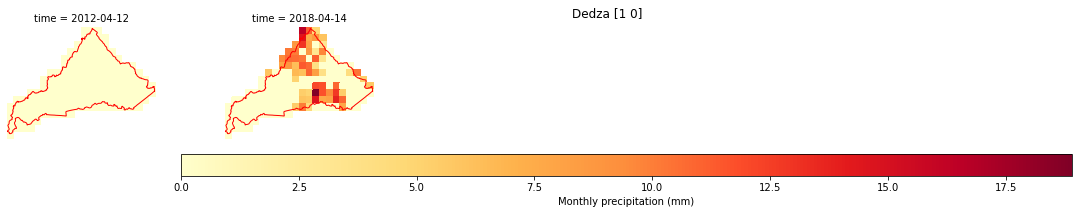

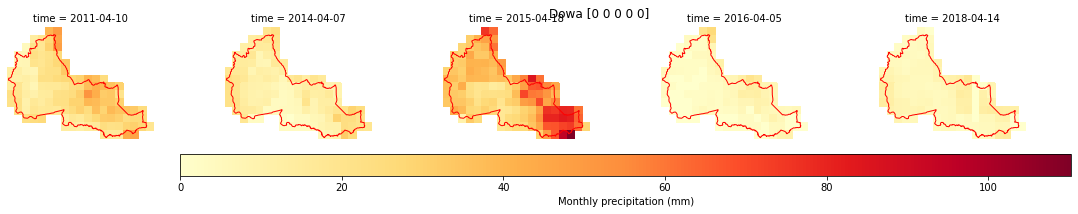

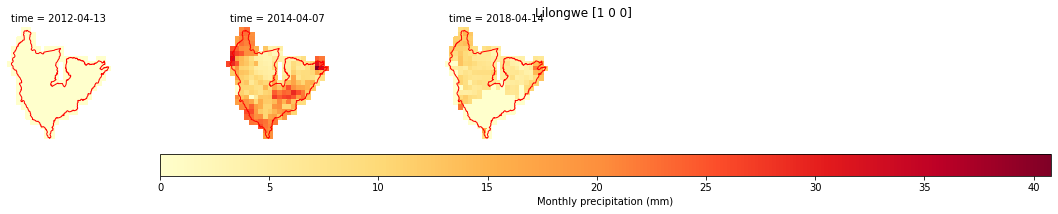

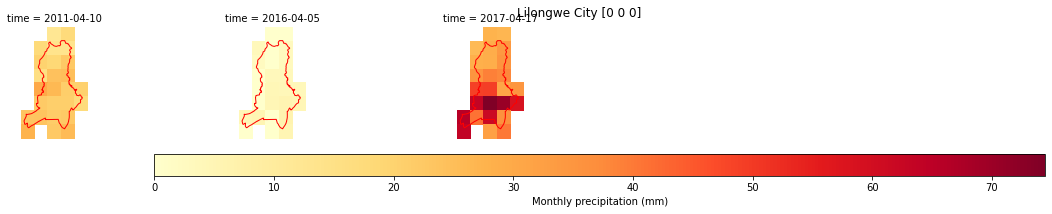

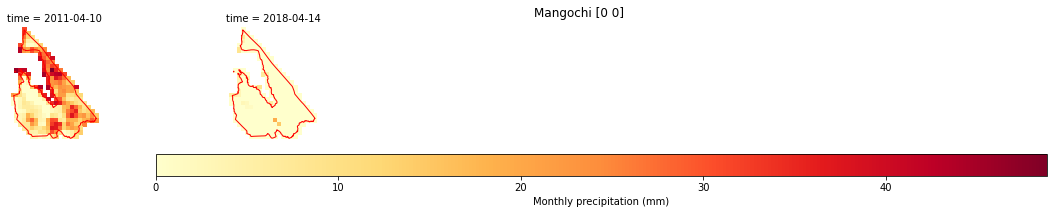

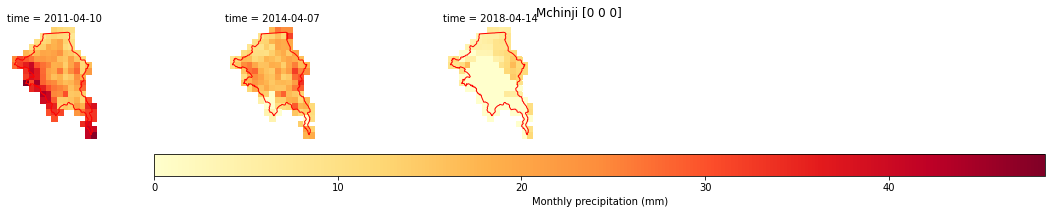

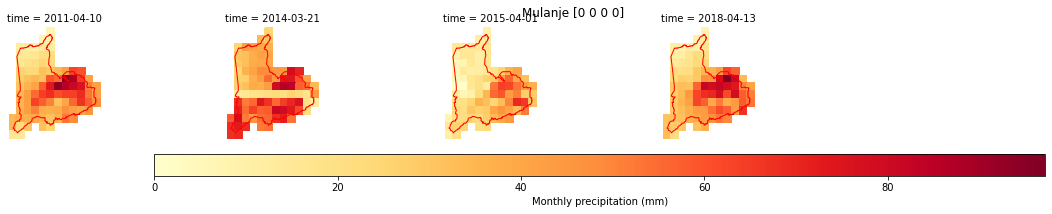

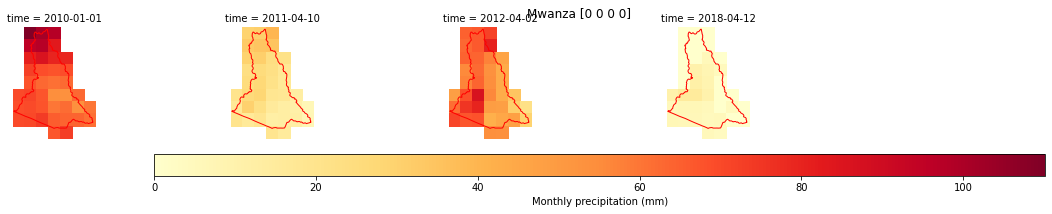

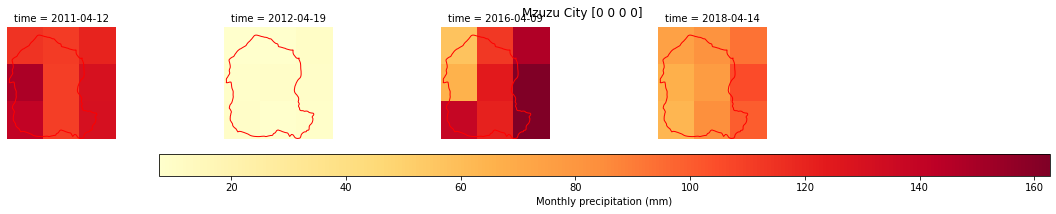

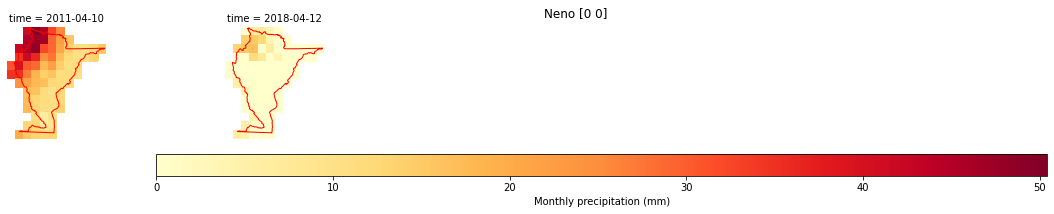

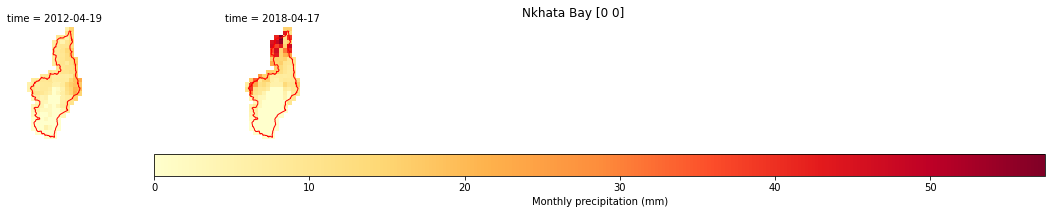

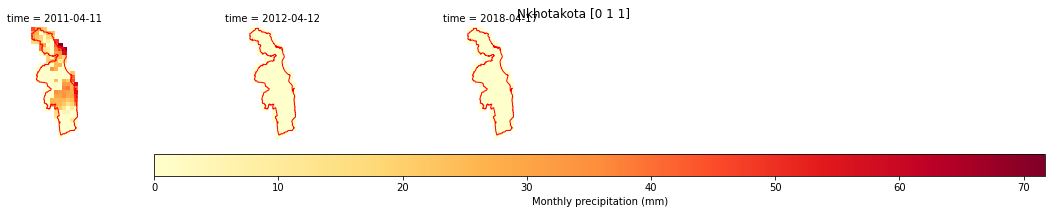

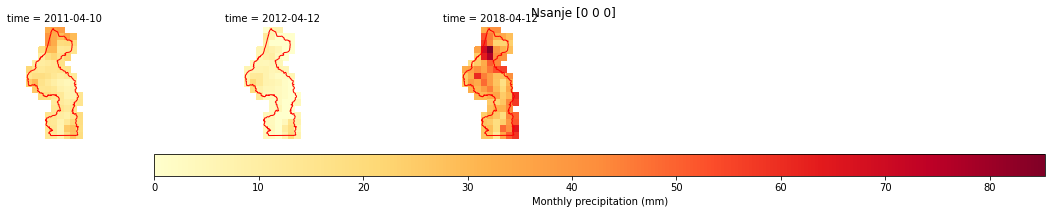

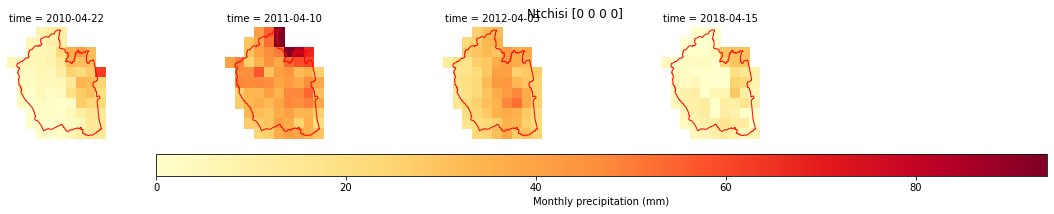

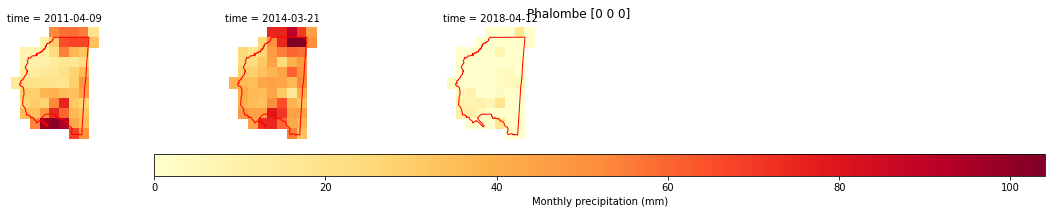

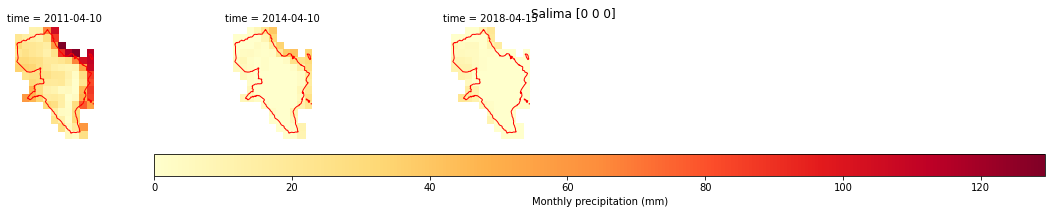

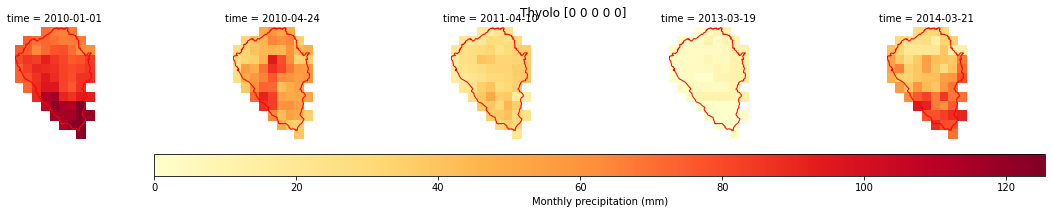

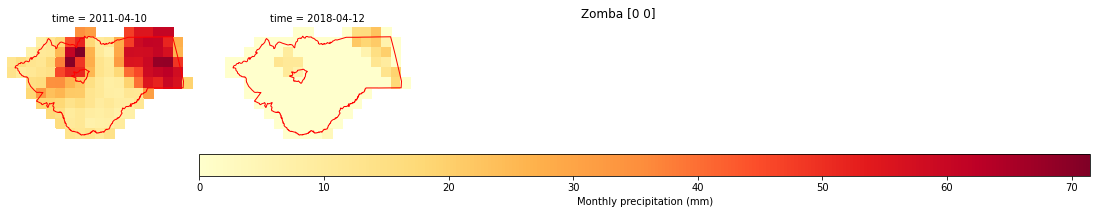

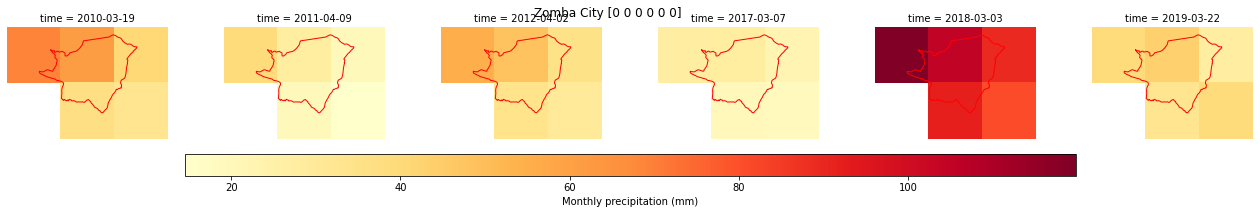

In [75]:
df_comb_ds=df_comb[df_comb.dryspell_obs==1]
for a in df_comb_ds.ADM2_EN.unique():
    print(a)
    df_bound_sel_adm=df_bound_adm2[df_bound_adm2.ADM2_EN==a]
    ds_drys_clip_adm = ds_drys.rio.clip(df_bound_sel_adm.geometry.apply(mapping), df_bound_sel_adm.crs, all_touched=True)
    ds_drys_clip_adm_dates=ds_drys_clip_adm.sel(time=ds_drys_clip_adm.time.isin(df_comb_ds[df_comb_ds.ADM2_EN==a].date.unique()))
    #cannot make the facetgrid if only one occurence. For now leave them out since just exploration, but for completeness should somehow include them
    if len(ds_drys_clip_adm_dates.time)>1:
        g=ds_drys_clip_adm_dates.plot(
        col="time",
        col_wrap=6,
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "aspect": 40,
            "pad": 0.1,
            "label":"Monthly precipitation (mm)"
        },
        cmap="YlOrRd",
    )

        # df_bound = gpd.read_file(adm1_bound_path)
        for ax in g.axes.flat:
            df_bound_sel_adm.boundary.plot(linewidth=1, ax=ax, color="red")
            ax.axis("off")
        g.fig.suptitle(f"{a} {df_comb_ds[df_comb_ds.ADM2_EN==a].sort_values(by='date').dryspell_forec.values}")

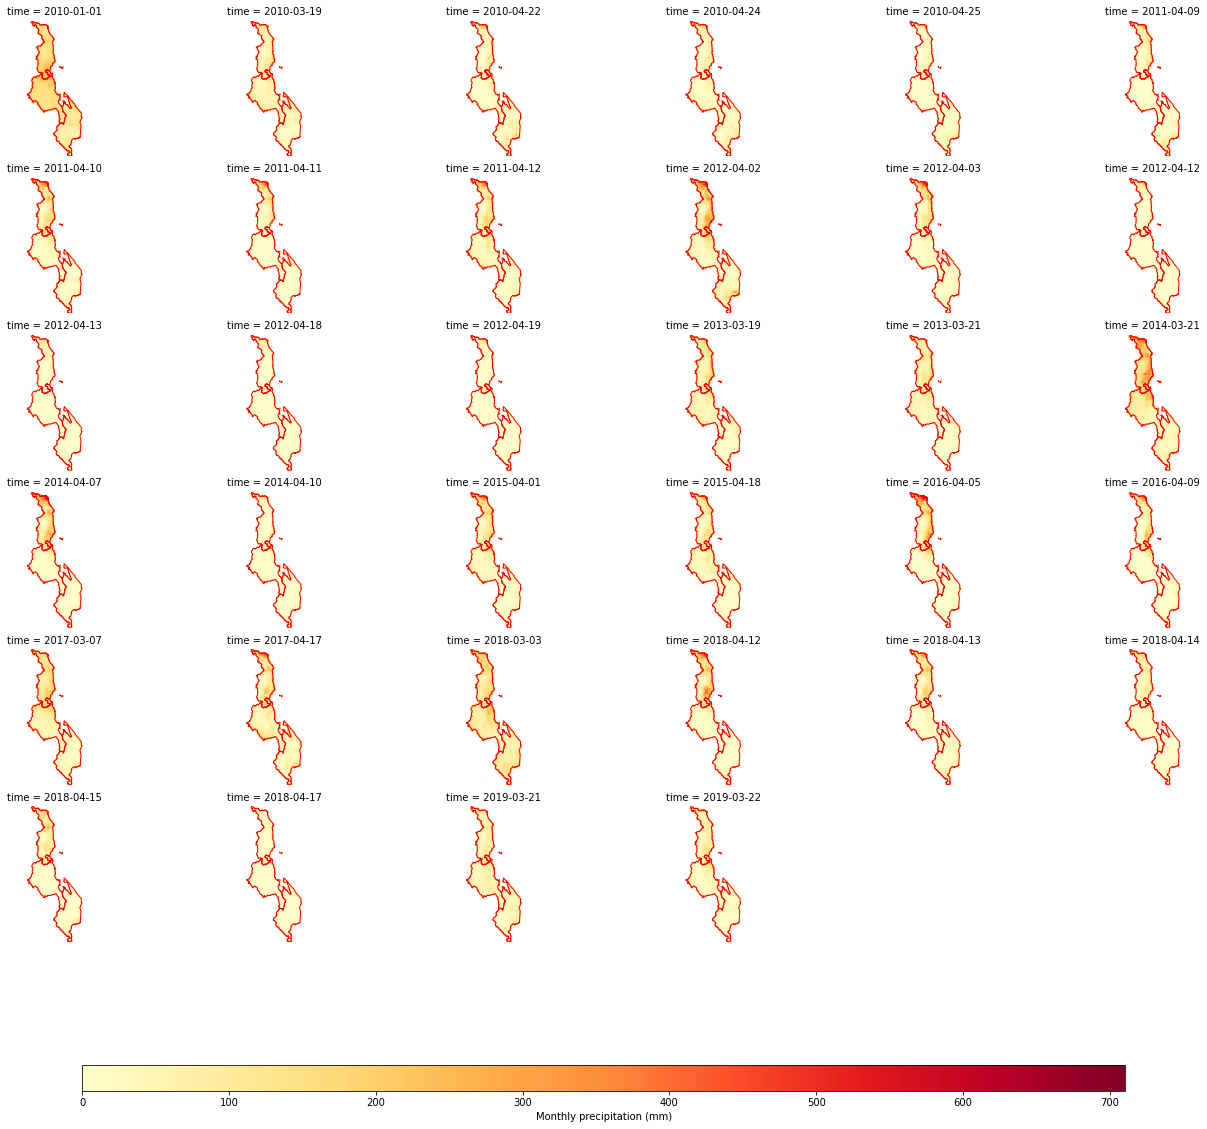

In [76]:
#show the data for each month of 2020, clipped to MWI
g=ds_drys_clip.plot( #sel(time=ds_drys_clip.time.dt.year.isin([2011])).plot(
    col="time",
    col_wrap=6,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label":"Monthly precipitation (mm)"
    },
    cmap="YlOrRd",
)

df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="red")
    ax.axis("off")

### Tests

Text(0.5, 1.0, 'Forecasted rainfall Balaka 2011')

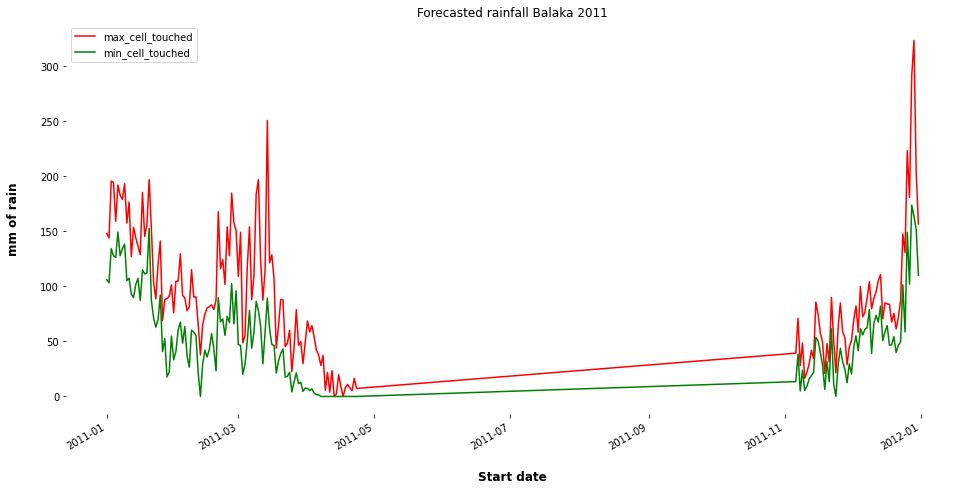

In [77]:
#inspect difference min and max cell touched
#plot data of Balaka for 2011
fig,ax=plt.subplots()
df_comb[(df_comb.date.dt.year==2011)&(df_comb.ADM2_EN=="Balaka")].sort_values(by="date").plot(x="date",y="max_cell_touched" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_comb[(df_comb.date.dt.year==2011)&(df_comb.ADM2_EN=="Balaka")].sort_values(by="date").plot(x="date",y="min_cell_touched" ,figsize=(16, 8), color='green',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("mm of rain", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Forecasted rainfall Balaka 2011")

##### Test how many days should be included

In [78]:
# #path to data start and end rainy season
# df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020.csv"))
# df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
# df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])

In [79]:
# #set the onset and cessation date for the seasons with them missing (meaning there was no dry spell data from start/till end of the season)
# df_rain_filled=df_rain.copy()
# df_rain_filled[df_rain_filled.onset_date.isnull()]=df_rain_filled[df_rain_filled.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
# df_rain_filled[df_rain_filled.cessation_date.isnull()]=df_rain_filled[df_rain_filled.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))

In [80]:
# #remove the adm2-date entries outside the rainy season for that specific adm2
# #before we included all forecasts within the min start of the rainy season and max end across the whole country
# total_days=0
# list_hist_rain_adm2=[]
# for a in df_rain.ADM2_EN.unique():
#     dates_adm2=pd.Index([])
#     for i in df_rain_filled.season_approx.unique():
#         seas_range=pd.date_range(df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)].onset_date.values[0],df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)].cessation_date.values[0])
#         dates_adm2=dates_adm2.union(seas_range)
#         total_days+=len(dates_adm2)
# #     list_hist_rain_adm2.append(df_hist_all[(df_hist_all.ADM2_EN==a)&(df_hist_all.date.isin(dates_adm2))])
# # df_hist_rain_adm2=pd.concat(list_hist_rain_adm2)

In [81]:
# total_days/32